# Artificial Prospect PipeLinE (APPLE): Assisting the analysis of hockey prospects using Recurring Neural Networks
by: [Connor Jung](https://twitter.com/ConnorJungle)

## Introduction

The NHL Draft is the proverbial reset of the NHL calendar. Teams re-evaluate the direction of their organization, make roster decisions, and welcome a new crop of 17-18 year old hockey players. Irrespective of pick position, each team's goal is to pick the players most likely to play in the NHL and to sustain success. Most players don't arrive to the NHL untill their early 20s, which leaves teams having to imagine what a player will be 4-5 years away. This project aims to model a player's development through time given their scoring data and estiamte the possible leagues and performance a player should expect in subsequent seasons. 

## Past Work

A project like this is only possible by virtue of hard work that came before it. Many of the core principles remain — such as NHL value, probability of success and league conversion, with differences only at the margins and in execution.

The list of prospect models is long and comprehensive and dates back to hockey analytics' infancy. The work of **APPLE**'s predecesors / inspiraitons: 

* [PCS](https://jetsnation.ca/2015/05/26/draft-analytics-unveiling-the-prospect-cohort-success-model) (Lawrence, Weissbock, Tanner)

* [SEAL](https://hockey-graphs.com/2016/06/15/seal-adjusted-scoring-and-why-it-matters-for-prospects/) (Hohl)

* [pGPS](https://nextgenhockey.ca/2019/06/21/pgps-draft-slot-valuations-for-the-2019-nhl-draft/) (Davies)

* [DEV](http://archive.is/2Odvy) (Speak)

* [Model Trees for Identifying Exceptional Players in the NHL Draft](https://arxiv.org/pdf/1802.08765.pdf) (Schulte, Liu, Li)

* NHLe ([Desjardins](http://www.behindthenet.ca/projecting_to_nhl.php) / [Vollman](http://www.hockeyabstract.com/testimonials/nhltranslations) / [Tulsky](https://archive.is/h3k9l) / Perry / [Bader](https://hockeyprospecting.com/about/))

* [NNHLe](https://cj-turtoro.shinyapps.io/NNHLe-writeup/) (Turtoro)

Much of the focus on NHL Draft / Prospect work concentrates on the following objectives (and are not mutually exclusive in application):
1. Scoring Translations
2. Player Comparables
3. Optimal Draft Value

In my view, these are the foundational concepts and questions that hockey analysts set out to tackle. **APPLE** is no different — the goal is to expand on the work that's come before, and offer a different approach that addresses shortcomings like:
1. Time dependencies (Age)
2. Selection bias
3. Arbitrary response variable (ie. 200 NHL game cutoff)

**APPLE** draws on the same principles of PCS / DEV in the sense that it is trying to capture in inherent risk / reward of each player's development, however, it strays away from selecting cohorts of players. We're also drawing from concepts of NHLe / NNHLe in that we're trying to estimate league equivalencies of production, albeit in season y+1 not in season y. Lastly, we're no longer using a binary classification on 200 NHL GPs as the threshold for NHL success.

## Methodology

I wrote about a prospect model last year, with the introduction of the Probability Peers prospects model (PPer). Unlike its predecssors, pGPS / PCS, the PPer was a regression model (similar to DEV). Since the data span across more leagues than just the CHL, I wanted to avoid some selection bias. PPer was most similar to DEV in that it was a binary classification fit on NHL Success (200 GP), with clusters fit using K-means on height / weight / probability of success. In the end, I came away still feeling unsastified having not really addressed the issues with the response variable (arbirary 200 GP cutoff for measure of NHL success), and taking into consideration that each player season is not indepedent — violating a key assumption of linear regression. It was just a few weeks later my friend [Nicole Fitzgerald](https://ninkle.github.io/) (Microsoft, soon to be MILA institute), who works in ML research, proposed these issues could be addressed as an LSTM time series problem.

That got me thinking.

Most time series problems using Neural Networks, specifically the RNN architecture, leverages deep learning frameworks like LSTM to encode historic information about the timeseries to aid in prediction. Many examples of pytorch/keras tutorials look at Stock Price prediction. Hockey players are assets for their organizations, I thought the analogue was close enough so here we are.  

The LSTM architecture, put simply, uses sequential data to updates cell states, hidden states, and produces an output. That output is the prediction for that time-step and will be compared against the ground truth in training. The cell and hidden states are updated as sequential data is passed through the network. 

![lstm_architecture.png](lstm_architecture.png)

The analog hockey use-case is you treat each player as a sequence that begins when they're 17 and ends when they're 23. Each player is initialized with the same hidden, cell state when we begin at year _y_. Then, we iteratively pass input data about the player's league, performance, measurements and other player features. The model produces an output for each time-step, ie. player performance in y+1.

What this allows us to accomplish is predict any future player performance entirely by past performance history. The goal is for the LSTM architecture to capture time-dependent, complex non-linear patterns as players develop, and to trace their path to NHL success. 

The main philosophical change to **APPLE** was trying to evaluate player development — treating time as a meaningful dimension in the problem. Not only is player age important in player development, but there are implications on salary cap and asset management as soon a player is drafted. Previous work didn't seem dynamic or global enough to accomplish this. Evaluating a prospect / pick is a careful balance between risk and reward, much like trading stocks. The goal is to model both risk and reward components separately and to bring it all together at the end to give us a time-dependent value, cut off at the age where teams lose entry-level contract rights. **APPLE** is composed on 3 main models. Using a similar set of player features as PPer we:
* Predict what League player plays in y+1
* Predict player Scoring conditioned on league in y+1
* Impute remaining features 

## Data Processing 

Let's take a look at how we transform our data to prepare for modelling. Since we're using Neural Networks, we need to prepare the data so we get 1 player per batch, and their season performance is passed iteratively. Let's start off by partitioning on unique players:

In [78]:
players = X.index.droplevel(-1).unique() # get number indices
n_players = players.shape[0] # number of players in the dataset
n_players

26516

We begin with ~69,000 player seasons across 24 leagues between 2005-2019. That's 26,516 player batches that will be fed into our LSTM RNN.  We will be padding player careers so the season dimension of the player tensor will always be 7 in length. We're going to split 70/30 for training and test datasets. Which will give us 18561 * 7 = 129,927 observations for training and 55,685 observations for our validation. One thing I noticed in the validation / EDA steps that I want to mention before the modelling section is the distribution of player seasons by league. The count of NCAA player seasons is quite high, representing >16% of the sample, which gives pause. High NCAA representation meant a lot of non-zero predictions for NCAA in the following season even if that transition is seldom observed (ie. Liiga -> NCAA is impossible). 

With that said, I wanted to ensure that train / test datasets were stratified by league so that league proportion was consistent between samples. It appears well stratified given the following lollipop plot:

![player_count_split.png](player_count_split.png)

Data pre-processing is one of the most important steps, it's where we implement the assumptions we make about our data. Broadly, the steps taken are as followed:
1. Read-in player and season data from eliteprospects, and join 
2. Calculate Age information at the season level
3. Collapse player league season information
* Aggregate player seasons intra-league (Sum) -> Aggregate player season intra-season (Max GP)
4. Split data into X, y datasets and Min-Max feature scale (Also create a train/test split)
5. Pad player seasons
* Padding is a pre-processing technique for Neural Networks, specific to handling different sized sequences as we have with player careers. This helps the model train when sequences are all the same length 
6. Generate Player Batches to feed through Network 

After we've pre-processed our data, let's take a peak at how the sequences are set up to feed into our Neural Network. We have a list of player padded seasons, that will have to reshape into a Tensor that's shaped [player, season, features], the array looks like:

In [51]:
train_seq[1]

array([[ 1.        ,  0.13513514,  0.29545455,  0.        ,  0.        ,
         0.38      ,  0.20567376,  0.84      ,  0.06666667,  0.11111111,
         0.1175    ,  0.07758621,  0.16197183,  0.1372549 ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

## Model Training

Now that we've prepared our data to pass to our LSTM, it's time to actually create our model object. Both Keras (a higher level API that sits on top of Tensorflow) and PyTorch are both intuitive Python wrappers of Deep Learning frameworks. The choice to go with PyTorch came down to the flexibility of the api, and its reputation for being more pythonic. This was my first implementation of an RNN so I gravitated towards a more python friendly use-case.

Implementing the model came down to a few steps:
1. Create a model class that inherents the pytorch module
2. Initialize the model class with a few hyperparameters
3. Initialize the activation functions needed
4. Write a forward function for your model 

The way I wrote the forward function is one of the reasons I chose pytorch for this implementation, since it's quite specific to our use case. For each player that's fed forward, a new hidden and cell state need to be initialized, as you don't want correlations / information between players to persist. We then loop over the 7 player seasons passing one season at a time to the LSTM with hidden state that's being updated after each season. I also added a second activation function in forward because it's possible to return negative values after the linear projection, but we all konw that player points per game cannot be lower than 0. I keep track of which inputs were padded, and only return true predictions so that loss is only calculated on true observations. Once we the model's forward function, we can now train the model.

In [30]:
import torch.nn as nn
import torch

class Model(nn.Module):
    def __init__(self, input_size=1, hidden_size=100, lstm_layers=2, output_size=1):
        
        super().__init__()
        self.start = time.time()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, lstm_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)  
        self.relu = nn.ReLU()

    def forward(self, seasons):

        ht = torch.zeros(1, 1, self.hidden_size)   # initialize hidden state
        ct = torch.zeros(1, 1, self.hidden_size)  # initialize cell state
        predictions = torch.Tensor([]) # to store our predictions for season t+1

        hidden = (ht, ct)
        
        for idx, season in enumerate(seasons):  # here we want to iterate over the time dimension
            lstm_input = torch.FloatTensor(season).view(1,1,len(season)) # LSTM takes 3D tensor
            out, hidden = self.lstm(lstm_input, hidden) # LSTM updates hidden state and returns output
            pred_t = self.linear(out) # pass LSTM output through a linear activation function
            pred_t = self.relu(pred_t) # since performance is non-negative we apply ReLU
            
            predictions = torch.cat((predictions, pred_t)) # concatenate all the predictions

        return predictions
        
input_size = X.shape[1]
output_size = 1
hidden_size = X.shape[1] * 2

model = Model(input_size, hidden_size, output_size)

trainer = Trainer(train_seq, 
                  train_target, 
                  test_seq, 
                  test_target, 
                  model, 
                  epochs=10, 
                  lr=0.001) 
trainer.train()

Running epoch: 1
epoch:   1 loss: 0.04886024
Running epoch: 2
Running epoch: 3
Running epoch: 4
Running epoch: 5
Running epoch: 6
epoch:   6 loss: 0.04610709
Running epoch: 7
Running epoch: 8
Running epoch: 9
epoch:   9 loss: 0.0362003446
Total Model Training Runtime: 85.00000000 mins


## APPLE Architecture

Now that we've trained our models, each will act as their own component of the higher level **APPLE** model. **APPLE**'s architecture follows an iterative / recusive structure, that can be traced using directed graph networks. Every simulated season is assigned a node in the network, and because of the "recursive" structure, each node only has one season directed to it. 

We briefly talked about **APPLE**'s architecture in the methodology section. In pseudo-code, the following function simulates a player's developement in till they reach the base case. Intuitively, this essentially creates independent timelines across nodes at each age, and that node is coniditioned on just one node. With that we can calculate the NHL likelihood at age 23 since all the logits sum to 1. This gives us a level of risk, for the reward side of the equation we're calculating the production a player would expect at each NHL season. We get our Expected Value by summing all the products of NHL expected points at age 23 by the Conditional Probability of that node.  

![apple_architecture.png](apple_architecture.png)

## Results

Let's look at an example, Alex Newhook (one of my favourite prospects from last year's draft) is an 19 year old prospect who just finished they Draft + 1 season in the NCAA. We pass this past season into **APPLE** to simualte his 20 year old season, which produces three possible outcomes {NHL, AHL, NCAA} based on his scoring and other player features. We can then estimate his scoring and the process repeats itself untill he reaches his hypothetical 23 year old season.

**APPLE** thinks Alex Newhook has an **_87%_** chance to make the NHL by 23. At that strong a likelihood to play in the NHL, his expected NHL Value over in the 5 seasons since being drafted is **_~135.7 points_**.

[19:45:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
--- Simulating Seasons --- Alex Newhook --- Age: 19
--- Simulation Complete --- Alex Newhook --- Age: 20
--- Simulating Seasons --- Alex Newhook --- Age: 20
--- Simulation Complete --- Alex Newhook --- Age: 20
--- Simulating Seasons --- Alex Newhook --- Age: 21
--- Simulating Seasons --- Alex Newhook --- Age: 21
--- Simulation Complete --- Alex Newhook --- Age: 21
--- Simulating Seasons --- Alex Newhook --- Age: 22
--- Simulating Seasons --- Alex Newhook --- Age: 22
--- Simulation Complete --- Alex Newhook --- Age: 22


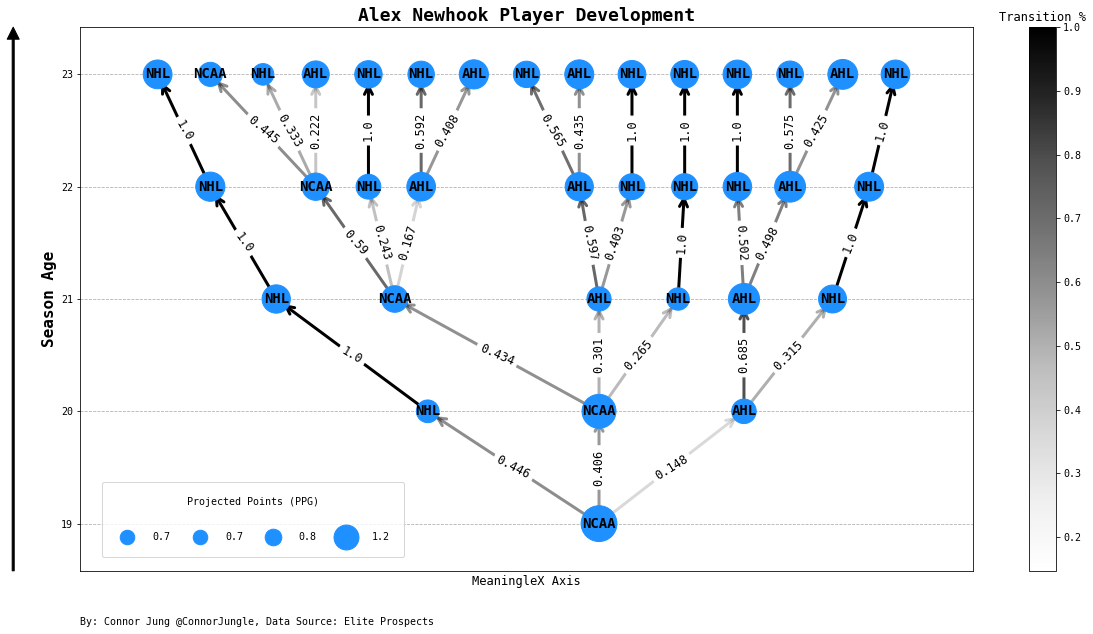

In [26]:
from generate_player_seasons import GeneratePlayer

player = GeneratePlayer()

player.initialize_player('320307')
player.simulate_player_development()
player.generate_network_graph()
player.plot_network_graph()

In [27]:
player.player_value

{'playerid': '320307',
 'player_name': 'Alex Newhook',
 'nhl_likelihood': 0.87,
 'most_likelihood_nhl_node': 21,
 'nhl_expected_value': 135.7}

### Team Prospect Pipelines

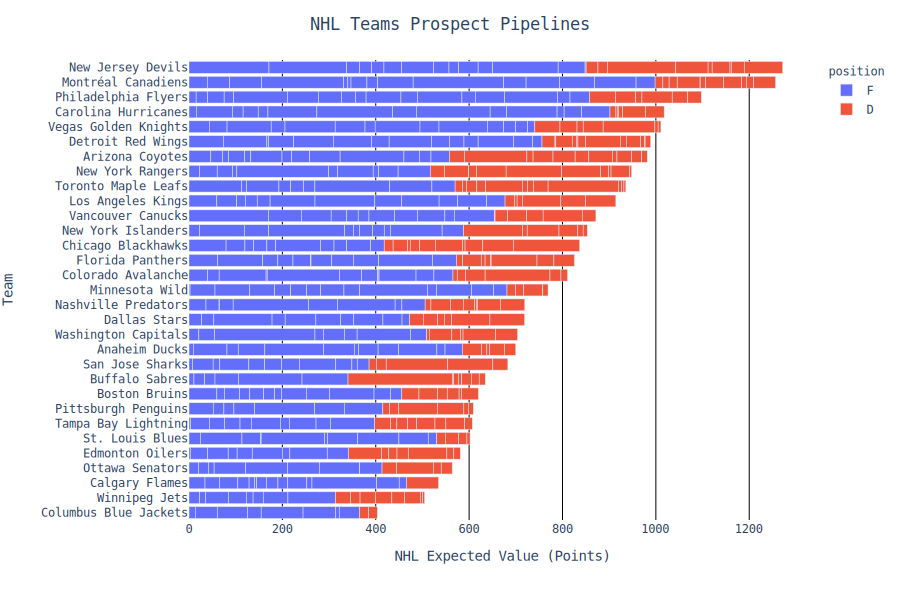

In [91]:
import plotly.express as px

data = pd.read_csv('nhl_prospects_expected_values.csv')
df = data.reset_index()

fig = px.bar(df, 
             y='draft_team',
             x="nhl_expected_value", 
             color='position',
             hover_data=['player_name'],
             height=600,
            )

fig.update_layout(title={"text" : "NHL Teams Prospect Pipelines",
                         'x':0.5,
                         'xanchor': 'center'},
                  font=dict(family="monospace",
                            size=12),
                  xaxis={'title' : 'NHL Expected Value (Points)',
                         'gridcolor' : 'black',
                        'showgrid': True},
                  yaxis={'title' : 'Team',
                      'categoryorder':'array', 
                         'categoryarray':df.groupby('draft_team').nhl_expected_value.sum().sort_values().index},
                 plot_bgcolor='rgb(255,255,255)'
                 )

fig.show("svg", height=600, width=900)

## Model Evaluation

## League prediction model

I decided to go with the baseline xgboost model for predicting what league a player is likely to play. The LSTM architecture quickly overfit the data, and became very confident in its predictions even with 23 possible leagues. The LSTM accuracy was quite good, but since the model was very confident in classification, the log-loss was a lot higher than the baseline.

Since I was more interested in the possible outcomes of leagues, the baseline xgboost multi-class model produced more general outputs. With incredible work done by Scott Lundberg, we can now visualize boosted tree models to see what happening under the hood.

Let's take a look at what's most important in predicting a player will play in the NHL in y+1:

![league_xgb_shap_plot.png](league_xgb_shap_plot.png)

The feature importance plot of the league prediction model is interesting. Not only can we see which features are most leveraged in the trees, but we can also see how its distribution affects the output (positively/negatively). What stands out:
* There are some non-linearilies in `draft_pick`
* The older you are, the more likely you're to play in the NHL next year
* The importance of `perc_team_a` which attempts to capture players who bare a higher responsibility of scoring for their team

### Train set League Model

In [86]:
league_model_train

,Accuracy,Log-Loss
LSTM,0.86,0.53
xgboost,0.84,0.57


### Test set League Model

In [85]:
league_model_test

,Accuracy,Log-Loss
LSTM,0.80,1.60
xgboost,0.84,0.58


## Scoring Prediction Model

### Train set Scoring Model

In [84]:
perf_model_train

,MSE,R^2
LSTM,0.033,0.70
xgboost,0.050,0.54


### Test Set Scoring Model

In [83]:
perf_model_test

,MSE,R^2
LSTM,0.06,0.48
xgboost,0.05,0.54


### Model Fit

![xgb-scatter-train.png](xgb-scatter-train.png)

![lstm-scatter-train.png](lstm-scatter-train.png)

The RNN LSTM outperforms the baseline xgboost by quite a large margin in R^2 and MSE in training.  

![xgb-scatter-test.png](xgb-scatter-test.png)

![lstm-scatter-test.png](lstm-scatter-test.png)

Baseline xgboost performs slightly better than RNN LSTM in test set results using R^2 and MSE.

### Distribution of Predicted Values

![scoring_xgb_distplot_test.png](scoring_xgb_distplot_test.png)

![scoring-lstm-distplot-test.png](scoring-lstm-distplot-test.png)

Given that out-of-sample results were worse for the RNN LSTM in terms of R^2 and MSE, we can't conclude that it's better than xgboost, but I'm comfortable with the RNN LSTM's results given that the distribution of outputs do fit ground truth more generally than the baseline.

## Limitations

At the onset, we stated that **APPLE** is trying to quantify Risk and Reward conditioned on a player's time-dependent performance. There is a fear of over-engineering the task at hand. Model complexity needs to be top of mind for any analyst, becauuse the trade-off between bias and variance affects how we interpret our results. 

First, let's talk about model fit. Typically, it's hard to decisively beat xgboost in regression problems based on my experience with hockey data (I'd also point to Kaggle competition winners since 2017). Comparing the baseline xgboost and LSTM when predicting scoring performance in y+1, the training set improvement by MSE and R^2 are conclusive. However, when we evaluate the models on the test set, the baseline xgboost tends to do better in these metrics. Interestingly, if we look at the distribution of predicted values, the LSTM does tend to fit the grouth truth a lot better. It appears that the LSTM model tends to have high variance error, given the difference in MSE between train / test sets — characteristics that the model is overfitting. Perhaps LSTM isn't a decsive improvement over xgboost, and other model architectures (ie. Transformers, CNN, etc.) may be better suited for the problem. 

Second, there is no measure of uncertainty in **APPLE**'s performance projections. If Alex Newhook plays his 20 year old season in the NHL, the model predicts 0.5 PPG (points per game) but we lack any confidence interval or range of possible performance. This is important because performance projections become inputs to future predictions, meaning outliers can heavily influence predictions downstream.

Third, training neural networks can take a lot of time, resources and proper optimization frameworks. This implementation focused more on developping a model that 1) learns something, anything 2) outperforms benchmark 3) produces reasonable outputs. There are probably marginal improvements on both the baseline xgboosts models and LSTM models if we threw more computing resources, time at the problem and used training optimization techniques. For example, while it's standard to use the ADAM optimizer — which keeps an exponentially decaying average of past gradients, I did not include any dropout or regularization, and I did not implement early stopping. These are all elements that should increase model performance, make predictions more robust, and be less prone to overfitting.

Last, RNNs typically use model output as inputs for the next time-step in training. When predicting player development, we have no choice but to use model outputs as inputs in hypothetical seasons, however we use ground truth performance at each time-step in training. This is a concept called Teacher Forcing, and will most likely lead to better results using ground truth than training using the model outputs as inputs. A balanced approach leveraging both Teacher Forcing and Model Outputs can provide the best of both worlds. For example, we could choose to use ground truth 50% of the time, and use model outputs the other 50%.

## Closing Thoughts

The goal for **APPLE** was to create a novel solution to the old problem of player development. It draws heavily on core principles of its predecessors, while applying modern deep learning techniques. There is a balance that has to be struck when setting your sights on new model applications, the fear of over engineering the problem is high. To combat the common tropes of deep learning frameworks I want to address the limitations of **APPLE** in future iterations by implementing some bootstrapping methods, regularization and early stopping. 

The application for this model is quite widespread, from pre-draft rankings, analyzing team prospect pipelines, and fantasy. The NHL draft has been one of my passions since attending the '06 draft in Vancouver as a kid, and then undoubtedly hooked when discovered hockeydb.com and its sorting feature by draft class. Hopefully this model adds to the fury of draft coverage, discussion and excitement as we move closer to the 2020 draft.

I've started working on creating a [beta web-application](https://apple-model.herokuapp.com/prospects) to host the model outputs, and would love feedback on the model, the data visualization and any questions/concerns people may have. 